In [104]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Input, Lambda, Concatenate
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomBrightness, RandomContrast
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from os import listdir
import extract
import cv2
import matplotlib.pyplot as plt

In [120]:
input_shape = (320, 320, 3)
base_model = ResNet50(
    include_top=False, classes=5,
    input_shape=input_shape,
)
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [106]:
tf.get_logger().setLevel('ERROR')

In [121]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.3, fill_mode='constant', fill_value=0),
    RandomTranslation(0.4, 0.4, fill_mode='constant', fill_value=0),
    RandomBrightness(0.4),
    RandomContrast(0.6)
], name="data_augmentation")

weight_nn = Sequential([
    Input(shape=(1,)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='relu')
])

inputs = Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

image_nn = Model(inputs, x)

concatted = Concatenate()([image_nn.output, weight_nn.output])
x = Dropout(0.2)(concatted)
outputs = Dense(5, activation='softmax')(x)

model = Model([image_nn.input, weight_nn.input], outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 32)           64          ['input_13[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 dropout_16 (Dropout)           (None, 32)           0           ['dense_20[0][0]']         

In [122]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

In [142]:
df = pd.read_csv('Camera/weights.csv')
df = df.set_index('name')
# df.loc['can_cola_1.jpg']['weight']

In [143]:
all_label = ['can', 'paper_cup', 'paper_box', 'paper_milkbox', 'plastic']
label_count = len(all_label)

In [144]:
labels = []
images = []
weights = []
path = 'Camera/Preprocessed/'
for i, cat in enumerate(["can", "paper", "plastic"]):
    dir = listdir(f'{path}{cat}/')
    for file in dir:
        fullpath = f'{path}{cat}/{file}'
        img = cv2.imread(fullpath)
        # if img.shape[0] > img.shape[1]:
        #     img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        # img = extract.garbage_extract(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        weights.append(df.loc[file[:-17] + file[-4:]]['weight'])
        # remove '_preprocessed'
        labels.append(df.loc[file[:-17] + file[-4:]]['label'])

In [145]:
images = np.array(images)
weights = np.array(weights)
labels = np.eye(label_count)[np.array(labels).astype(int)]
im_train, im_val, w_train, w_val, y_train, y_val = train_test_split(
    images, weights, labels, test_size=0.1
)

# im_val, im_test, w_val, w_test, y_val, y_test = train_test_split(
#     im_val, w_val, y_val, test_size=0.5
# )

In [146]:
labels = []
images = []
weights = []
path = 'Camera/Test/'
for i, cat in enumerate(["can", "paper", "plastic"]):
    dir = listdir(f'{path}{cat}/')
    for file in dir:
        fullpath = f'{path}{cat}/{file}'
        img = cv2.imread(fullpath)
        # if img.shape[0] > img.shape[1]:
        #     img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        # img = extract.garbage_extract(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        weights.append(df.loc[file[:-17] + file[-4:]]['weight'])
        # remove '_preprocessed'
        labels.append(df.loc[file[:-17] + file[-4:]]['label'])

im_test = np.array(images)
w_test = np.array(weights)
y_test = np.eye(label_count)[np.array(labels).astype(int)]

In [147]:
print(im_train.shape, im_val.shape, im_test.shape)
print(w_train.shape, w_val.shape, w_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(185, 320, 320, 3) (21, 320, 320, 3) (94, 320, 320, 3)
(185,) (21,) (94,)
(185, 5) (21, 5) (94, 5)


In [130]:
model.fit([im_train, w_train], y_train, epochs=20, validation_data=([im_val, w_val], y_val))

Epoch 1/20
6/6 [==============================] - 28s 3s/step - loss: 1.8797 - accuracy: 0.4054 - val_loss: 0.8489 - val_accuracy: 0.7143
Epoch 2/20
6/6 [==============================] - 18s 3s/step - loss: 0.9731 - accuracy: 0.7027 - val_loss: 0.4130 - val_accuracy: 0.9048
Epoch 3/20
6/6 [==============================] - 18s 3s/step - loss: 0.7075 - accuracy: 0.7514 - val_loss: 0.3109 - val_accuracy: 0.8571
Epoch 4/20
6/6 [==============================] - 18s 3s/step - loss: 0.5119 - accuracy: 0.8162 - val_loss: 0.1873 - val_accuracy: 1.0000
Epoch 5/20
6/6 [==============================] - 18s 3s/step - loss: 0.3559 - accuracy: 0.8865 - val_loss: 0.1399 - val_accuracy: 1.0000
Epoch 6/20
6/6 [==============================] - 18s 3s/step - loss: 0.3517 - accuracy: 0.8919 - val_loss: 0.1159 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 18s 3s/step - loss: 0.2866 - accuracy: 0.9243 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 8/20
6/6 [==================

In [167]:
# model.evaluate([im_val, w_val], y_val)
with tf.device('/cpu:0'):
    loss, accuracy = model.evaluate([im_test, w_test], y_test)
    print("Loss: %f, Accuracy: %.7f" % (loss, accuracy))
# for i in range(len(w_test)):
#     prob = model.predict([im_test[i:i+1], w_test[i:i+1]])
#     pred = prob.argmax(-1)[0]
#     actual = y_test[i].argmax(-1)
#     print(prob)
#     print(f'Pred: {all_label[pred]}, Actual = {all_label[actual]}')
#     plt.imshow(im_test[i])
#     plt.show()

3/3 [==============================] - 9s 3s/step - loss: 0.1302 - accuracy: 0.9362
Loss: 0.130185, Accuracy: 0.9361702


In [119]:
model.save("model_without_preprocess.h5")

In [165]:
# model = tf.keras.models.load_model("model_without_preprocess.h5")
model = tf.keras.models.load_model("model_without_preprocess_finetuned.h5")

1/1 [==============================] - 0s 34ms/step
[[0.00000627 0.0000036  0.99978226 0.00020434 0.0000036 ]]
[42.91]


['can', 'paper_cup', 'paper_box', 'paper_milkbox', 'plastic']

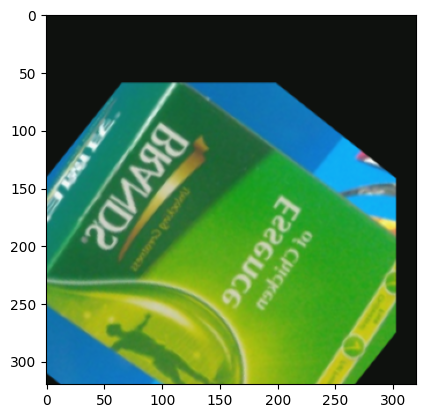

In [160]:
np.set_printoptions(suppress=True)
i = 9
test = data_augmentation(im_val[i:i+1], training=True)
# test = im_val[i:i+1]
print(model.predict([test, w_val[i:i+1]]))
print(w_val[i:i+1])
plt.imshow(test[0]/255)
all_label

In [156]:
# base_model.trainable = True
model.get_layer('resnet50').trainable = True
model.summary()

model.compile(
    optimizer=Adam(1e-6),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 32)           64          ['input_10[0][0]']               
                                                                                                  
 input_11 (InputLayer)          [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 dropout_12 (Dropout)           (None, 32)           0           ['dense_15[0][0]']         

In [157]:
with tf.device('/cpu:0'):
    model.fit([im_train, w_train], y_train, batch_size=32, epochs=10, validation_data=([im_val, w_val], y_val))

Epoch 1/10
6/6 [==============================] - 77s 11s/step - loss: 0.0888 - accuracy: 0.9838 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 70s 12s/step - loss: 0.0882 - accuracy: 0.9784 - val_loss: 0.0490 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 68s 11s/step - loss: 0.0635 - accuracy: 0.9838 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 69s 12s/step - loss: 0.0601 - accuracy: 0.9946 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 68s 11s/step - loss: 0.0491 - accuracy: 0.9946 - val_loss: 0.0317 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 68s 11s/step - loss: 0.0524 - accuracy: 0.9892 - val_loss: 0.0271 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 70s 12s/step - loss: 0.0395 - accuracy: 1.0000 - val_loss: 0.0239 - val_accuracy: 1.0000
Epoch 8/10
6/6 [===========

In [161]:
model.save("model_without_preprocess_finetuned.h5")